Step 1 : Installation Of Tools Required

In [1]:
pip install yfinance pandas numpy matplotlib scikit-learn keras tensorflow streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


Step 2 : Import Libaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

Step 3 : Fetch Stock Data

In [3]:
df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
df = df[['Close']]
df.dropna(inplace=True)

# Flatten the MultiIndex
df.columns = ['_'.join(col).strip() for col in df.columns.values]

df.reset_index(inplace=True) # Reset index to make 'Ticker' a regular column

# Calculate MA20 and RSI after resetting the index
df['MA20'] = df['Close_AAPL'].rolling(window=20).mean()
df['RSI'] = 100 - (100 / (1 + df['Close_AAPL'].pct_change().rolling(window=14).mean()))

df.head()

/tmp/ipython-input-3-806050307.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


,Date,Close_AAPL,MA20,RSI
0,2015-01-02,24.288582,NaN,NaN
1,2015-01-05,23.604330,NaN,NaN
2,2015-01-06,23.606552,NaN,NaN
3,2015-01-07,23.937569,NaN,NaN
4,2015-01-08,24.857307,NaN,NaN


Step 4 : Normalize and Prepare Data

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Select only the numerical columns for scaling, excluding the 'Date' column
numerical_cols = ['Close_AAPL', 'MA20', 'RSI']
scaled_data = scaler.fit_transform(df[numerical_cols])

# Sequence creation
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        # Ensure that the data being appended to X is numerical
        X.append(data[i-window:i])
        # Append only the target feature (Close_AAPL, which is the first column) to y
        y.append(data[i, 0]) # Assuming Close_AAPL is the first column
    # Convert to numpy arrays and ensure y is 1D
    X = np.array(X)
    y = np.array(y).reshape(-1,) # Explicitly reshape y to 1D
    return X, y

X, y = create_sequences(scaled_data)

Step 5 : Build LSTM Model


In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2]))) # Updated input_shape
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,101 (476.96 KB)

 Trainable params: 122,101 (476.96 KB)

 Non-trainable params: 0 (0.00 B)

Step 6 : Train Model

In [6]:
model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: nan
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: nan
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: nan
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: nan
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: nan
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: nan
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: nan
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: nan
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: nan
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: nan


Step 7: Plot Predictions vs Actual

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


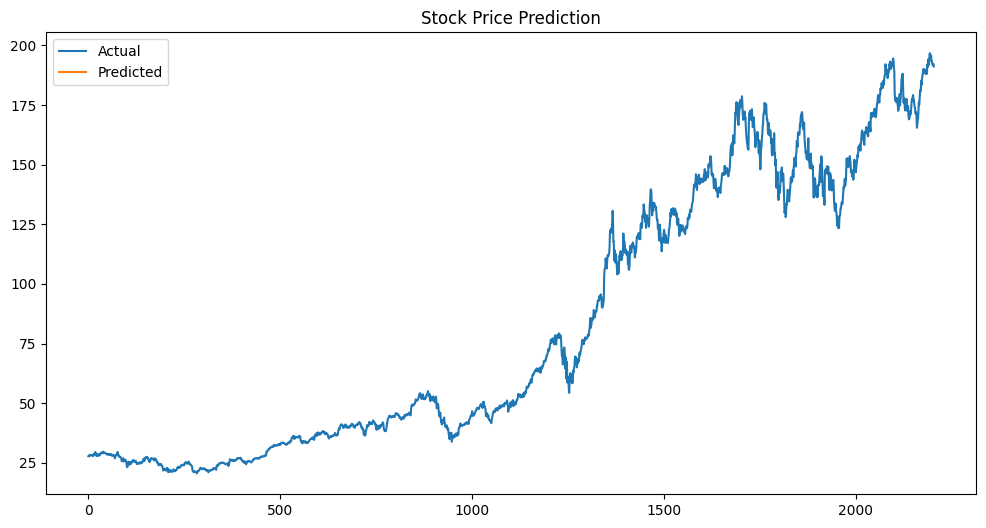

In [7]:
predicted_prices = model.predict(X)

# Create a dummy array with the same number of features as the training data for predicted prices
dummy_array_predicted = np.zeros((predicted_prices.shape[0], scaled_data.shape[1]))

# Place the predicted prices in the column corresponding to the 'Close_AAPL' feature
# Assuming 'Close_AAPL' was the first column in scaled_data
dummy_array_predicted[:, 0] = predicted_prices.flatten()

# Inverse transform the dummy array for predicted prices
predicted_prices = scaler.inverse_transform(dummy_array_predicted)[:, 0]

# Create a dummy array with the same number of features as the training data for actual prices
dummy_array_actual = np.zeros((y.shape[0], scaled_data.shape[1]))

# Place the actual prices (y) in the column corresponding to the 'Close_AAPL' feature
dummy_array_actual[:, 0] = y.flatten()

# Inverse transform the dummy array for actual prices
actual_prices = scaler.inverse_transform(dummy_array_actual)[:, 0]


plt.figure(figsize=(12,6))
plt.plot(actual_prices, label="Actual")
plt.plot(predicted_prices, label="Predicted")
plt.title("Stock Price Prediction")
plt.legend()
plt.show()

Step 8: Integrate Moving Average & RSI Indicators

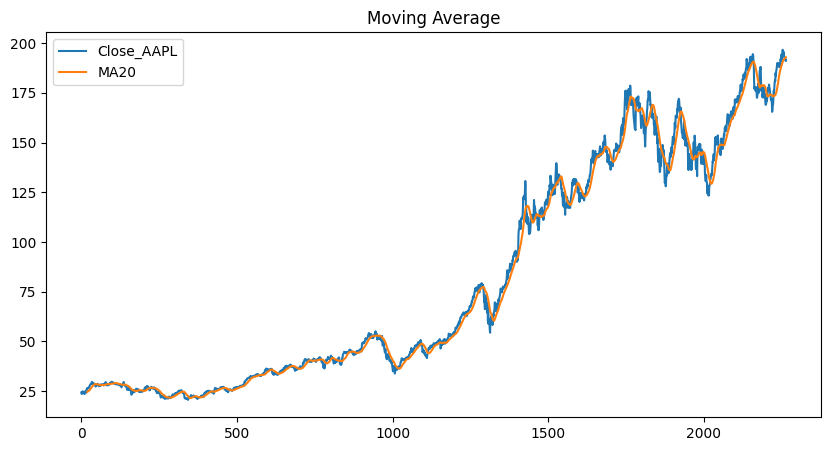

In [8]:
df['MA20'] = df['Close_AAPL'].rolling(window=20).mean()
df['RSI'] = 100 - (100 / (1 + df['Close_AAPL'].pct_change().rolling(window=14).mean()))

df[['Close_AAPL', 'MA20']].plot(figsize=(10,5), title='Moving Average')
plt.show()

Step 9: Deploy with Streamlit

In [9]:
import streamlit as st
import pandas as pd

st.title("📈 Stock Price Prediction with LSTM")

streamlit_df = df[['Date', 'Close_AAPL', 'MA20']].copy()
streamlit_df['Date'] = pd.to_datetime(streamlit_df['Date'])
st.line_chart(streamlit_df.dropna().set_index('Date'))

st.line_chart(pd.DataFrame({'Actual': actual_prices.flatten(), 'Predicted': predicted_prices.flatten()}))

2025-07-26 08:22:38.852 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 08:22:39.228 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-26 08:22:39.229 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 08:22:39.230 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 08:22:40.044 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 08:22:40.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 08:22:40.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 08:22:40.125 Thread 'MainThread': mi

DeltaGenerator()

In [10]:
print(df.columns)

Index(['Date', 'Close_AAPL', 'MA20', 'RSI'], dtype='object')


In [11]:
print(df.columns)
display(df.head())

Index(['Date', 'Close_AAPL', 'MA20', 'RSI'], dtype='object')


,Date,Close_AAPL,MA20,RSI
0,2015-01-02,24.288582,NaN,NaN
1,2015-01-05,23.604330,NaN,NaN
2,2015-01-06,23.606552,NaN,NaN
3,2015-01-07,23.937569,NaN,NaN
4,2015-01-08,24.857307,NaN,NaN


In [12]:
print(df.columns)

Index(['Date', 'Close_AAPL', 'MA20', 'RSI'], dtype='object')


In [13]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (2204, 60, 3)
Shape of y: (2204,)


In [14]:
model.save('model.h5')
